# 1. 데이터 불러오기

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# csv파일 불러오기
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
test_df.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


# 2. EDA

In [5]:
# 컬럼별 정보 확인하기
train_df.info()

# train데이터 세트에는 Age, Cabin, Embarked 컬럼에 Nan값이 있는것을 확인하였다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# 컬럼별 정보 확인하기
test_df.info()

# test데이터 세트에는 Age, Fare, Cabin 컬럼에 Nan값이 있는것을 확인하였다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### 2.1 Survived

In [7]:
# 데이터값 확인하기
train_df['Survived'].value_counts().to_frame()

,Survived
0,549
1,342


<AxesSubplot:ylabel='Survived'>

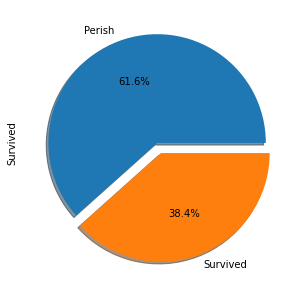

In [8]:
# 사망(0)과 생존(1)의 수치를 시각화 하였다.
fig, ax = plt.subplots(figsize=(14,5))
labels = ['Perish', 'Survived']
 
train_df['Survived'].value_counts().plot.pie(explode=[0,0.1], shadow=True, autopct='%1.1f%%', labels=labels)


⭐️ 해석

* 사망과 생존의 총 비율을 파이차트로 나타낸 것인데, 안타깝게도 사망률이 생존률보다 대략 23퍼정도 높게 나왔다.

### 2.2 Gender

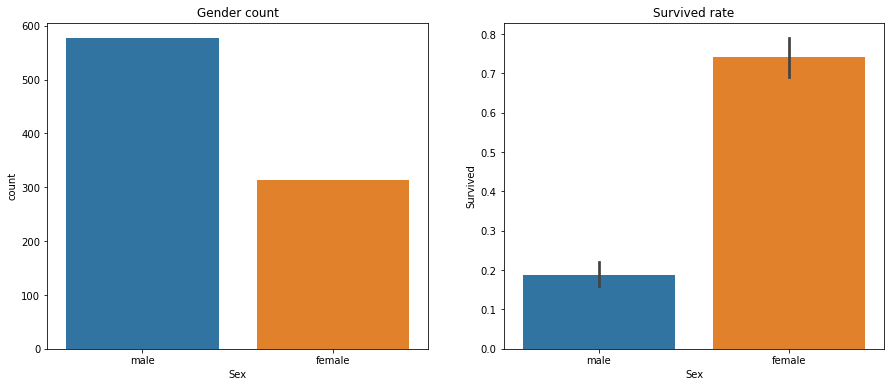

In [9]:
# 성별에 따라 사망자의 수를 시각화 하는 과정이며
# 왼쪽 남녀별 생수, 오른쪽은 생존자수의 비율이다.

fx, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title("Gender count")
axes[1].set_title("Survived rate")
fig1_gen = sns.countplot(data=train_df, x='Sex', ax=axes[0])
fig2_gen = sns.barplot(data=train_df, x='Sex', y='Survived', ax=axes[1])

In [10]:
# 성별로 그룹화를 시켜 생존의 평균값을 나타내었다.
train_df.groupby('Sex').Survived.mean().to_frame()

,Survived
Sex,
female,0.742038
male,0.188908


⭐️ 해석 

* 남성승객이 더 많음에도 불구하고, 대다수의 생존자가 여성임을 알 수 있다. 여성의 생존률이 남성의 생존률보다 약 4배 높다는 것을 확인할 수 있었다.

### 2.3 Pclass

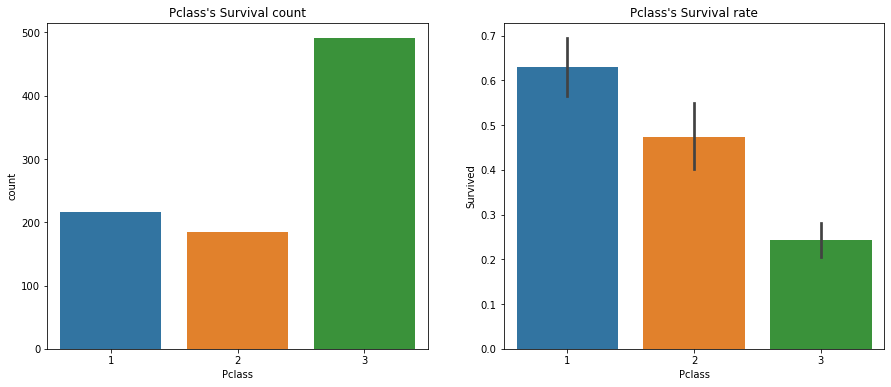

In [11]:
fx, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title("Pclass's Survival count")
axes[1].set_title("Pclass's Survival rate")
fig1_pclass = sns.countplot(data=train_df, x='Pclass', ax=axes[0])
fig2_pclass = sns.barplot(data=train_df, x='Pclass',y='Survived', ax=axes[1])

In [12]:
print(train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


⭐️ 해석
* Pclass에 따른 승객 수는 3 > 1 > 2 순서이고
* 클래스별 생존율은 1 > 2 > 3 순서이다.
* 따라서 1등석 승객은 생존률이 더 높다.

### 2.4 Age

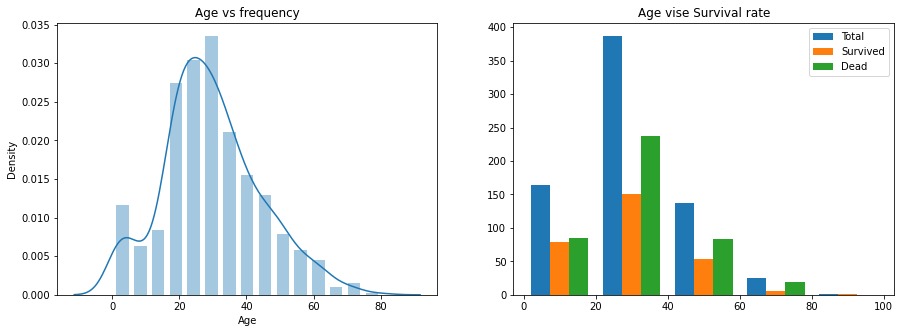

In [13]:
import warnings
warnings.filterwarnings('ignore')

# 나이에 따른 분포

training_age_n = train_df.Age.dropna(axis=0)

fx, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].set_title("Age vs frequency")
axes[1].set_title("Age vise Survival rate")
fig1_age = sns.distplot(a=training_age_n, bins=15, ax=axes[0], hist_kws={'rwidth':0.7})  # hist_kws를 통해 막대사이의 간격을 띄어준다.

# 나이에 따른 생존, 사망비율 시각화

pass_survived_age = train_df[train_df.Survived == 1].Age
pass_dead_age = train_df[train_df.Survived == 0].Age

axes[1].hist([train_df.Age, pass_survived_age, pass_dead_age], bins=5, range=(0, 100), label=['Total', 'Survived', 'Dead'])
axes[1].legend()
plt.show()

⭐️ 해석

* 10대 후반 ~ 30대까지의 분포도가 가장 많으며

* 사망비율 또한 20~40대 사이에 가장 많은 것을 확인할 수 있었다.

### 2.5 Fare

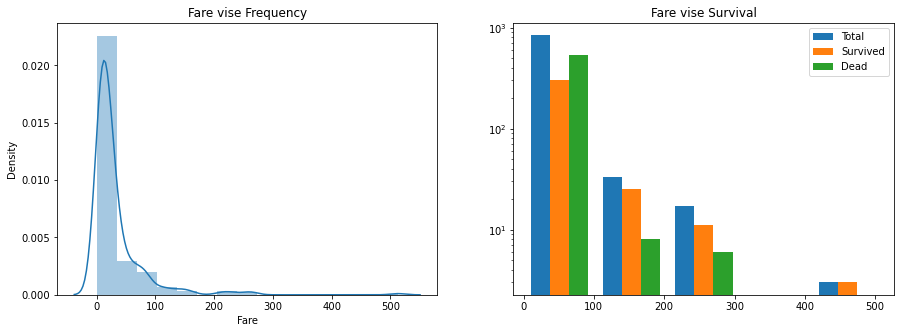

In [14]:
fx, axes = plt.subplots(1, 2, figsize=(15,5))
fig1_fare = sns.distplot(a=train_df.Fare, bins=15, ax=axes[0])
fig1_fare.set_title('Fare vise Frequency')

# 생존자의 요금과 사망자의 요금을 알아보았다.
pass_survived_fare = train_df[train_df.Survived == 1].Fare
pass_dead_fare = train_df[train_df.Survived == 0].Fare

axes[1].hist(x=[train_df.Fare, pass_survived_fare, pass_dead_fare], bins=5, label=['Total', 'Survived', 'Dead'], \
        log=True)  # 요금 숫자가 너무 커서 log를 취했다.
axes[1].legend()
axes[1].set_title('Fare vise Survival')
plt.show()

⭐️ 해석

* 0-100사이에서 생존률과 사망률 모두 높다
* Fare의 비율이 높을수록 생존 확률이 높아진다.

### 2.6 Embarked

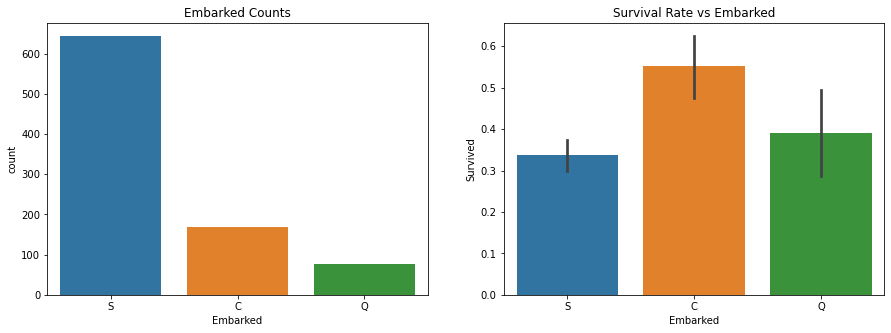

In [15]:
# Embarked별 수와 Embarked에 따른 생존율을 시각화 하였다.

fx, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].set_title('Embarked Counts')
axes[1].set_title('Survival Rate vs Embarked')
fig1_embarked = sns.countplot(x=train_df.Embarked, ax=axes[0])
fig2_embarked = sns.barplot(x=train_df.Embarked, y=train_df.Survived, ax=axes[1])

⭐️ 해석

* 힝구별 승객이 가장 많은 곳은 S이며, C항구에서 탑승한 승객의 사망률이 가장 높은것을 확인할 수 있었다.

# 3. 전처리

### Name

In [16]:
train_df['Title'] = train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_df['Title'] = test_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [17]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [18]:
train_df['Title'].value_counts().to_frame()

# Title이 심하게 불균형하다. 따라서 통합을 하기위해 남성직함을 Mr, 여성직함을 Mrs로 바꿀 필요가 있어보인다.

,Title
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Mlle,2
Col,2
Major,2
the Countess,1


In [19]:
# 최대한 drop을 하지 않고 많은 컬럼을 사용하기 위해서, 이름또한 단일화 작업을 하여 Title컬럼에 넣어주었다.
# 단일화 작업없이 그대로 카테고리화 시켜 진행을 했을때, 데이터의 총 량에 비해 복잡도가 너무 올라가는 경향이 있었기 때문에
# 여성의 성으로 간주되는 값들은 Miss, 남성의 성으로 간주되는 값들은 Mr로 대체해주는 작업을 진행하였다.

train_df['Title'] = train_df['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss')
test_df['Title'] = test_df['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss')
train_df['Title'] = train_df['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr')
test_df['Title'] = test_df['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr')

In [20]:
train_df['Title'].value_counts().to_frame()

# 전보다 더 깔끔해진 것을 확인할 수 있다.

# Mr : 남성
# Miss : 미혼 여성
# Mrs : 기혼 여성
# Master : 너무 어려 "Mr" 붙일 수 없는 소년
# Dr : 박사, 의사
# Rev : 목사, 신부

,Title
Mr,525
Miss,188
Mrs,125
Master,40
Dr,7
Rev,6


### Age

In [21]:
# 빼자..

# # Train
# train_df.loc[ train_df['Age'] <= 10, 'Age_clean'] = 0
# train_df.loc[(train_df['Age'] > 10) & (train_df['Age'] <= 16), 'Age_clean'] = 1
# train_df.loc[(train_df['Age'] > 16) & (train_df['Age'] <= 20), 'Age_clean'] = 2
# train_df.loc[(train_df['Age'] > 20) & (train_df['Age'] <= 26), 'Age_clean'] = 3
# train_df.loc[(train_df['Age'] > 26) & (train_df['Age'] <= 30), 'Age_clean'] = 4
# train_df.loc[(train_df['Age'] > 30) & (train_df['Age'] <= 36), 'Age_clean'] = 5
# train_df.loc[(train_df['Age'] > 36) & (train_df['Age'] <= 40), 'Age_clean'] = 6
# train_df.loc[(train_df['Age'] > 40) & (train_df['Age'] <= 46), 'Age_clean'] = 7
# train_df.loc[(train_df['Age'] > 46) & (train_df['Age'] <= 50), 'Age_clean'] = 8
# train_df.loc[(train_df['Age'] > 50) & (train_df['Age'] <= 60), 'Age_clean'] = 9
# train_df.loc[ train_df['Age'] > 60, 'Age_clean'] = 10

# # Test
# test_df.loc[ test_df['Age'] <= 10, 'Age_clean'] = 0
# test_df.loc[(test_df['Age'] > 10) & (test_df['Age'] <= 16), 'Age_clean'] = 1
# test_df.loc[(test_df['Age'] > 16) & (test_df['Age'] <= 20), 'Age_clean'] = 2
# test_df.loc[(test_df['Age'] > 20) & (test_df['Age'] <= 26), 'Age_clean'] = 3
# test_df.loc[(test_df['Age'] > 26) & (test_df['Age'] <= 30), 'Age_clean'] = 4
# test_df.loc[(test_df['Age'] > 30) & (test_df['Age'] <= 36), 'Age_clean'] = 5
# test_df.loc[(test_df['Age'] > 36) & (test_df['Age'] <= 40), 'Age_clean'] = 6
# test_df.loc[(test_df['Age'] > 40) & (test_df['Age'] <= 46), 'Age_clean'] = 7
# test_df.loc[(test_df['Age'] > 46) & (test_df['Age'] <= 50), 'Age_clean'] = 8
# test_df.loc[(test_df['Age'] > 50) & (test_df['Age'] <= 60), 'Age_clean'] = 9
# test_df.loc[ test_df['Age'] > 60, 'Age_clean'] = 10

### SibSp(형제 또는 배우자의 수) + Parch(함께 탑승한 부모, 아이의 수)

In [22]:
train_df['Family_size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Family_size'] = test_df['SibSp'] + test_df['Parch'] + 1

In [23]:
train_df['Family_size'] = pd.cut(train_df.Family_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])
test_df['Family_size'] = pd.cut(test_df.Family_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])

In [24]:
train_df['Family_size'].value_counts()

Solo        537
Small       292
Big          49
Very big     13
Name: Family_size, dtype: int64

### Cabin

In [25]:
# Cabin컬럼에는 맨 앞의 알파벳만 가져오기로 하였다. 그 결과 A,B,C,D,E,F,G,T를 얻을 수 있었고
# Cabin컬럼의 많은 Nan값은 Pclass로 그룹한 후, median값을 채워넣어 주었다.

train_df['Cabin'].str[:1].value_counts()

mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'T': 7
}

train_df['Cabin_clean'] = train_df['Cabin'].str[:1]
train_df['Cabin_clean'] = train_df['Cabin_clean'].map(mapping)
train_df['Cabin_clean'] = train_df.groupby('Pclass')['Cabin_clean'].transform('median')

test_df['Cabin_clean'] = test_df['Cabin'].str[:1]
test_df['Cabin_clean'] = test_df['Cabin_clean'].map(mapping)
test_df['Cabin_clean'] = test_df.groupby('Pclass')['Cabin_clean'].transform('median')

train_df['Cabin_clean'].value_counts()

5.0    491
2.0    216
4.5    184
Name: Cabin_clean, dtype: int64

In [26]:
test_df['Cabin_clean'].value_counts()

5.0    311
2.0    107
Name: Cabin_clean, dtype: int64

In [27]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family_size,Cabin_clean
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Small,5.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Small,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Solo,5.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Small,2.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Solo,5.0


# 4. 데이터세트 나누기 및 모델 학습

In [28]:
# x는 특성값, y는 타겟값이다. 
# 특성에는 passengerId, Age값 외에는 전부 사용하였다. Age를 사용하지 않은 가장 큰 이유는 서브미션 스코어값 때문이다.
# 여러 컬럼을 빼보고 전처리도 바꾸는 작업을 하다가, Age컬럼을 빼고 Name컬럼의 호칭을 따로 분리하여 전처리를 했을때
# 스코어값이 더 높게 나오는것을 확인하였다.
# Name앞에 호칭만 따로 Title컬럼에 넣는 과정이 있었는데, 서양같은 경우엔 어린아이에게 쓰는 호칭,
# 어른에게 쓰는 호칭 등이 정해져 있는것으로 알고 있고 실제 Name컬럼에는 모든 값들에 호칭이 정해져 있었기 때문에
# 이 호칭을 Age컬럼대신 사용하기로 하였다.

y = train_df['Survived']
features = ['Pclass', 'Fare', 'Title', 'Embarked', 'Family_size', "Cabin_clean"]
X = train_df[features]
X.head()

,Pclass,Fare,Title,Embarked,Family_size,Cabin_clean
0,3,7.2500,Mr,S,Small,5.0
1,1,71.2833,Mrs,C,Small,2.0
2,3,7.9250,Miss,S,Solo,5.0
3,1,53.1000,Mrs,S,Small,2.0
4,3,8.0500,Mr,S,Solo,5.0


In [29]:
numerical_cols = ['Fare']
categorical_cols = ['Pclass', 'Title', 'Embarked', 'Family_size', 'Cabin_clean']

In [30]:
numerical_transformer = SimpleImputer(strategy='median')

# 범주형 데이터에 대해 가장 빈번한값을 결측값대신 입력
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [31]:
# 숫자 및 범주형 데이터에 대한 전처리
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


SimpleImputer(strategy = 'median')은 Null값들을 모두 중앙값으로 바꿔주는 메서드이다.
그것을 numerical_transformer변수에 지정을 하였다.

Pipeline은 여러 처리 단계를 하나의 scikit-learn 추정기 형태로 묶어주는 파이썬 클래스이다. Pipeline은 fit, predict, score 메소드를 제공한다.

Pipeline을 사용하는 가장 일반적인 경우는 분류기 같은 지도 학습 모델과 전처리 단계를 연결할 때이다.

0으로 이루어진 벡터에 단 한개의 1의 값으로 해당 데이터의 값을 구별하는 것이 원핫 인코딩이다.

ColumnTransformer를 사용하여 범주 및 숫자 데이터 열에 다른 변환을 적용하는 방법.

### 랜덤 포레스트

In [74]:
# 그리드서치를 이용해서 최적의 하이퍼파라미터 결정
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

rf_param_grid = {'n_estimators' : [50,100,200,300], 'max_depth' : [3,4,5,6,7],
                 'max_leaf_nodes' : [1,2,3,4,5],
                'min_samples_split':range(2,100,10)}

rf_grid = GridSearchCV(rf, param_grid = rf_param_grid,n_jobs=-1, verbose=1)

In [75]:
# 파이프라인메서드를 이용하여, 모델에 전처리 바로 적용
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_grid)
])


In [44]:
import warnings
warnings.filterwarnings('ignore')

In [78]:
# 이부분이 조금 오래걸리지만 finished가 끝날때까지 기다린다.
titanic_pipeline.fit(X,y)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  5.9min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Title',
                                                   'Embarked', 'Family_size',
                                                   'Cabin_clean'])])),
                ('model',
                 GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
            

In [79]:
# 예측 타깃값 지정

X_test = test_df[features]
X_test.head()

,Pclass,Fare,Title,Embarked,Family_size,Cabin_clean
0,3,7.8292,Mr,Q,Solo,5.0
1,3,7.0000,Mrs,S,Small,5.0
2,2,9.6875,Mr,Q,Solo,5.0
3,3,8.6625,Mr,S,Solo,5.0
4,3,12.2875,Mrs,S,Small,5.0


In [80]:
# 예측

predictions = titanic_pipeline.predict(X_test)

In [85]:
# csv파일로 저장

output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('submission-6-1(Grid-RF).csv', index=False)

In [81]:
# 베스트 하이퍼파라미터 출력 - 최상의 매개변수 조합 확인
# 실행시 마다 결과값이 달라짐.

print(rf_grid.best_params_)

{'max_depth': 7, 'max_leaf_nodes': 5, 'min_samples_split': 62, 'n_estimators': 50}


In [84]:
# 훈련세트에 대한 점수 및 검증세트에 대한 점수
print("훈련세트에 대한 점수: ",titanic_pipeline.score(X, y))
print("검증세트에 대한 점수: ", rf_grid.best_score_)

훈련세트에 대한 점수:  0.8114478114478114
검증세트에 대한 점수:  0.8081350825434687


#### 랜덤포레스트 최상의 하이퍼파라미터로 학습진행하기

In [92]:
# 최상의 매개변수로 다시 실행하기
rf = RandomForestClassifier(n_estimators = 200, max_depth=5,
                           max_leaf_nodes = 5, min_samples_split = 72, n_jobs = -1, verbose = 1)

# verbose
# 표시되는 정보의 양을 결정합니다.
# 값 1을 사용하면 각 실행의 시간이 표시됩니다. 
# 2는 점수도 표시됨을 나타냅니다.
# 3은 접기 및 후보 매개변수도 표시됨을 나타냅니다

In [93]:
# 파이프라인메서드를 이용하여, 모델에 전처리 바로 적용
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf)
])


In [94]:
titanic_pipeline.fit(X,y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Title',
                                                   'Embarked', 'Family_size',
                                                   'Cabin_clean'])])),
                ('model',
                 RandomForestClassifier(max_depth=7, max_leaf_nodes=5,
                  

In [95]:
X_test = test_df[features]
X_test.head()

,Pclass,Fare,Title,Embarked,Family_size,Cabin_clean
0,3,7.8292,Mr,Q,Solo,5.0
1,3,7.0000,Mrs,S,Small,5.0
2,2,9.6875,Mr,Q,Solo,5.0
3,3,8.6625,Mr,S,Solo,5.0
4,3,12.2875,Mrs,S,Small,5.0


In [96]:
predictions = titanic_pipeline.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [97]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('submission-6-1.csv', index=False)

### 결정트리

In [113]:
# 그리드서치를 이용해서 최적의 하이퍼파라미터 결정
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt_param_grid = {'min_impurity_decrease':np.arange(0.0001, 0.001, 0.0001),
                'max_depth':range(2, 20, 1),
                'min_samples_split':range(2, 100, 10)}

dt_grid = GridSearchCV(dt, param_grid = dt_param_grid, n_jobs=-1, verbose=1)

In [114]:
# 파이프라인메서드를 이용하여, 모델에 전처리 바로 적용 
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', dt_grid)
])

In [115]:
# 이부분이 조금 오래걸리지만 finished가 끝날때까지 기다린다.
titanic_pipeline.fit(X,y)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 4624 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed:   10.4s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Title',
                                                   'Embarked', 'Family_size',
                                                   'Cabin_clean'])])),
                ('model',
                 GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
            

In [116]:
# 베스트 하이퍼파라미터 출력 - 최상의 매개변수 조합 확인
# 실행시마다 바뀐다..

print(dt_grid.best_params_)

{'max_depth': 15, 'min_impurity_decrease': 0.0005, 'min_samples_split': 2}


In [117]:
# 훈련세트에 대한 점수 및 검증세트에 대한 점수
print("훈련세트에 대한 점수: ",titanic_pipeline.score(X, y))
print("검증세트에 대한 점수: ", dt_grid.best_score_)

훈련세트에 대한 점수:  0.9001122334455668
검증세트에 대한 점수:  0.8384282217061075


In [101]:
X_test = test_df[features]
X_test.head()

,Pclass,Fare,Title,Embarked,Family_size,Cabin_clean
0,3,7.8292,Mr,Q,Solo,5.0
1,3,7.0000,Mrs,S,Small,5.0
2,2,9.6875,Mr,Q,Solo,5.0
3,3,8.6625,Mr,S,Solo,5.0
4,3,12.2875,Mrs,S,Small,5.0


In [ ]:
predictions = titanic_pipeline.predict(X_test)

In [ ]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('my_submission(dt).csv', index=False)

### KNN

In [107]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn_param_grid = {'n_neighbors':[1, 3, 5, 7, 9, 11]}

knn_grid = GridSearchCV(knn, param_grid = knn_param_grid, n_jobs=-1, verbose=1)

In [108]:
# 파이프라인메서드를 이용하여, 모델에 전처리 바로 적용
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', knn_grid)
])

In [109]:
# 이부분이 조금 오래걸리지만 finished가 끝날때까지 기다린다.
titanic_pipeline.fit(X,y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.9s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Title',
                                                   'Embarked', 'Family_size',
                                                   'Cabin_clean'])])),
                ('model',
                 GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
              

In [111]:
# 베스트 하이퍼파라미터 출력 - 최상의 매개변수 조합 확인
print(knn_grid.best_params_)

{'n_neighbors': 5}


In [112]:
# 훈련세트에 대한 점수 및 검증세트에 대한 점수
print("훈련세트에 대한 점수: ",titanic_pipeline.score(X, y))
print("검증세트에 대한 점수: ", knn_grid.best_score_)

훈련세트에 대한 점수:  0.8496071829405163
검증세트에 대한 점수:  0.7822986629841191


In [ ]:
X_test = test_df[features]
X_test.head()

In [ ]:
predictions = titanic_pipeline.predict(X_test)

In [ ]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('my_submission(knn).csv', index=False)

### 로지스틱

In [118]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr_param_grid = {'C':range(1,20,1)}

lr_grid = GridSearchCV(lr, param_grid = lr_param_grid, n_jobs=-1, verbose=1)

In [119]:
# 파이프라인메서드를 이용하여, 모델에 전처리 바로 적용
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lr_grid)
])

In [120]:
import warnings
warnings.filterwarnings('ignore')

# 이부분이 조금 오래걸리지만 finished가 끝날때까지 기다린다.
# 아마 warnings이 길게 뜨지만, 서브미션 스코어값을 산출하는데엔
# 전혀 문제가 없다.

titanic_pipeline.fit(X,y)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    0.8s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Title',
                                                   'Embarked', 'Family_size',
                                                   'Cabin_clean'])])),
                ('model',
                 GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
                

In [121]:
# 베스트 하이퍼파라미터 출력 - 최상의 매개변수 조합 확인
print(lr_grid.best_params_)

{'C': 19}


In [122]:
# 훈련세트에 대한 점수 및 검증세트에 대한 점수
print("훈련세트에 대한 점수: ",titanic_pipeline.score(X, y))
print("검증세트에 대한 점수: ", lr_grid.best_score_)

훈련세트에 대한 점수:  0.8294051627384961
검증세트에 대한 점수:  0.826031008725127


In [ ]:
X_test = test_df[features]
X_test.head()

In [ ]:
predictions = titanic_pipeline.predict(X_test)

In [ ]:
# 아마 warnings이 길게 뜨지만, 서브미션 스코어값을 산출하는데엔
# 전혀 문제가 없다.

output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('my_submission(lr).csv', index=False)

### 그레디언트 부스팅

In [102]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

gb_param_grid = {'n_estimators' : [50,100,200,300], 'max_depth' : [3,4,5,6,7],
                 'max_leaf_nodes' : [1,2,3,4,5],
                'min_samples_split':range(2,100,10)}

gb_grid = GridSearchCV(gb, param_grid = gb_param_grid,n_jobs=-1, verbose=1)

In [103]:
# 파이프라인메서드를 이용하여, 모델에 전처리 바로 적용
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', gb_grid)
])

In [104]:
titanic_pipeline.fit(X,y)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1632 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 2393 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3103 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4500 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.6min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Title',
                                                   'Embarked', 'Family_size',
                                                   'Cabin_clean'])])),
                ('model',
                 GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
        

In [105]:
# 베스트 하이퍼파라미터 출력 - 최상의 매개변수 조합 확인
print(gb_grid.best_params_)

{'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_split': 12, 'n_estimators': 300}


In [106]:
# 훈련세트에 대한 점수 및 검증세트에 대한 점수
print("훈련세트에 대한 점수: ",titanic_pipeline.score(X, y))
print("검증세트에 대한 점수: ", gb_grid.best_score_)

훈련세트에 대한 점수:  0.9023569023569024
검증세트에 대한 점수:  0.8350134957002073


In [ ]:
gb = GradientBoostingClassifier(n_estimators = 300, max_depth = 3, max_leaf_nodes = 5, min_samples_split = 12)

In [ ]:
# Bundle preprocessing and modeling code 
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', gb)
])

In [ ]:
titanic_pipeline.fit(X,y)

In [ ]:
X_test = test_df[features]
X_test.head()

In [ ]:
predictions = titanic_pipeline.predict(X_test)

In [ ]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('submission-6-2.csv', index=False)

# 결과

훈련세트와 검증세트 그리고 서브미션의 스코어값을 모두 따졌을때, 가장 이상적인 분류기는 랜덤포레스트와 로지스틱인것 같다. 하지만 이번 프로젝트의 핵심이 두 분류기의 서브미션 스코어 합산이 높은것이었기 때문에 랜덤포레스트와 그레이디언트 부스팅 알고리즘을 선택하였다.